# Fuzzing in the Large

In the past chapters, we have always looked at fuzzing taking place on one machine for a few seconds only.  In the real world, however, fuzzers are run on dozens or even thousands of machines; for hours, days and weeks; for one program or dozens of programs.  In such contexts, one needs an _infrastructure_ to _collect_ failure data from the individual fuzzer runs, and to _aggregate_ such data in a central repository.  In this chapter, we will examine such an infrastructure, the _FuzzManager_ framework from Mozilla.

**Prerequisites**

* This chapter requires basic knowledge on testing, e.g. from the [Introduction to testing](Intro_Testing.ipynb).
* This chapter requires basic knowledge on how fuzzers fork, e.g. from the [Introduction to fuzzing](Fuzzer.ipynb).

In [1]:
import bookutils

In [2]:
import Fuzzer

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.FuzzingInTheLarge import <identifier>
```

and then make use of the following features.


The Python `FuzzManager` package allows for programmatic submission of failures from a large number of (fuzzed) programs.  One can query crashes and their details, collect them into buckets to ensure thay will be treated the same, and also retrieve coverage information for debugging both programs and their tests.



## Collecting Crashes from Multiple Fuzzers

So far, all our fuzzing scenarios have been _one_ fuzzer on _one_ machine testing _one_ program.  Failures would be shown immediately, and diagnosed quickly by the same person who started the fuzzer.  Alas, testing in the real world is different.  Fuzzing is still fully automated; but now, we are talking about _multiple_ fuzzers running on _multiple_ machines testing _multiple_ programs (and versions thereof), producing _multiple_ failures that have to be handled by _multiple_ people.  This raises the question of how to manage all these activities and their interplay.

A common means to coordinate several fuzzers is to have a central _repository_ that collects all crashes as well as their crash information.  Whenever a fuzzer detects a failure, it connects via the network to a _crash server_, which then stores the crash information in a database.

In [3]:
# ignore
from graphviz import Digraph

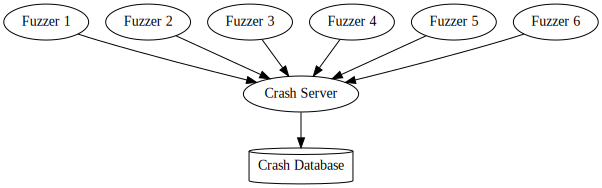

In [4]:
# ignore
g = Digraph()
server = 'Crash Server'
g.node('Crash Database', shape='cylinder')
for i in range(1, 7):
    g.edge('Fuzzer ' + repr(i), server)
g.edge(server, 'Crash Database')
g

The resulting crash database can be _queried_ to find out which failures have occurred – typically, using a Web interface.  It can also be _integrated_ with other process activities.  Most importantly, entries in the crash database can be linked to the _bug database_, and vice versa, such that bugs (= crashes) can be assigned to individual developers.

In such an infrastructure, collecting crashes is not limited to fuzzers.  Crashes and failures occurring in the wild can also be automatically reported to the crash server.  In industry, it is not uncommon to have crash databases collecting thousands of crashes from production runs – especially if the software in question is used by millions of people every day.

What information is stored in such a database?  

* Most important is the _identifier_ of the product – that is, the product name, version information as well as the platform and the operating system.  Without this information, there is no way developers can tell whether the bug is still around in the latest version, or whether it already has been fixed.

* For debugging, the most helpful information for developers are the _steps to reproduce_ – in a fuzzing scenario, this would be the _input_ to the program in question.  (In a production scenario, the user's input is not collected for obvious privacy reasons.)  

* Second most helpful for debugging is a _stack trace_ such that developers can inspect which internal functionality was active in the moment of the failure.  A _coverage_ map also comes in handy, since developers can query which functions were executed and which were not.

* If general failures are collected, developers also need to know what the expected behavior was; for crashes, this is simple, as users do not expect their software to crash.

All of this information can be collected automatically if the fuzzer (or the program in question) is set up accordingly.  

In this chapter, we will explore a platform that automates all these steps.  The _FuzzManager_ platform  allows to

1. _collect_ failure data from failing runs,
2. _enter_ this data into a centralized server, and
3. _query_ the server via a Web interface.

In this chapter, we will show how to conduct basic steps with FuzzManager, including crash submission and triage as well as coverage measurement tasks.

## Running a Crash Server

[FuzzManager](https://github.com/MozillaSecurity/FuzzManager) is a tool chain for managing large-scale fuzzing processes.  It is _modular_ in the sense that you can make use of those parts you need; it is _versatile_ in the sense that it does not impose a particular process.  It consists of a _server_ whose task is to collect crash data, as well as of various _collector utilities_ that collect crash data to send it to the server.

### Excursion: Setting up the Server

To run the examples in this notebook, we need to run a _crash server_ – that is, the _FuzzManager_ server.  You can either

1. Run your own server.  To do so, you need to follow the installation steps listed under "Server Setup" on the [FuzzManager](https://github.com/MozillaSecurity/FuzzManager) page.  The `FuzzManager` folder should be created in the same folder as this notebook.

2. Have the notebook start (and stop) a server.  The following commands following commands do this automatically.  They are meant for the purposes of this notebook only, though; if you want to experiment with your own server, run it manually, as described above.

In [5]:
import os
import sys
import shutil

In [6]:
# ignore
if 'CI' in os.environ:
    # Can't run this in our continuous environment,
    # since it can't run a headless Web browser
    sys.exit(0)

We start with getting the fresh server code from the repository.

In [7]:
if os.path.exists('FuzzManager'):
    shutil.rmtree('FuzzManager')

In [8]:
!git clone https://github.com/MozillaSecurity/FuzzManager

Cloning into 'FuzzManager'...
remote: Enumerating objects: 12305, done.
remote: Counting objects: 100% (2224/2224), done.
remote: Compressing objects: 100% (1085/1085), done.
remote: Total 12305 (delta 1470), reused 1716 (delta 1100), pack-reused 10081
Receiving objects: 100% (12305/12305), 5.60 MiB | 1.21 MiB/s, done.
Resolving deltas: 100% (8227/8227), done.


In [9]:
# ignore
# We use the stable release 0.4.1
!cd FuzzManager; git checkout 0.4.1

Note: switching to '0.4.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 81d591d chmod +x TaskStatusReporter


In [10]:
# ignore
!pip install -r FuzzManager/server/requirements.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown-it-py 1.1.0 requires attrs<22,>=19, but you have attrs 18.2.0 which is incompatible.
autopep8 1.5.7 requires pycodestyle>=2.7.0, but you have pycodestyle 2.5.0 which is incompatible.
astroid 2.6.6 requires lazy-object-proxy>=1.4.0, but you have lazy-object-proxy 1.3.1 which is incompatible.
astroid 2.6.6 requires wrapt<1.13,>=1.11, but you have wrapt 1.10.11 which is incompatible.
anyio 3.3.3 requires idna>=2.8, but you have idna 2.7 which is incompatible.


In [11]:
!cd FuzzManager; python server/manage.py migrate > /dev/null

We create a user named `demo` with a password `demo`, using [this handy trick](https://stackoverflow.com/questions/6244382/how-to-automate-createsuperuser-on-django).

In [12]:
!(cd FuzzManager; echo "from django.contrib.auth import get_user_model; User = get_user_model(); User.objects.create_superuser('demo', 'demo@fuzzingbook.org', 'demo')" | python server/manage.py shell)

We create a token for this user.  This token will later be used by automatic commands for authentication.

In [13]:
import subprocess
import sys

In [14]:
os.chdir('FuzzManager')
result = subprocess.run(['python', 
                         'server/manage.py',
                         'get_auth_token',
                         'demo'], 
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE)
os.chdir('..')

err = result.stderr.decode('ascii')
if len(err) > 0:
    print(err, file=sys.stderr, end="")

In [15]:
token = result.stdout
token = token.decode('ascii').strip()
token

'be1c528b7915dd88338d7737d01021f26d8bee8c'

In [16]:
# ignore
assert len(token) > 10, "Invalid token " + repr(token)

The token is stored in `~/.fuzzmanagerconf` in our home folder. This is the full configuration:

In [17]:
# ignore
home = os.path.expanduser("~")
conf = os.path.join(home, ".fuzzmanagerconf")

In [18]:
# ignore
fuzzmanagerconf = """
[Main]
sigdir = /home/example/fuzzingbook
serverhost = 127.0.0.1
serverport = 8000
serverproto = http
serverauthtoken = %s
tool = fuzzingbook
""" % token

In [19]:
# ignore
with open(conf, "w") as file:
    file.write(fuzzmanagerconf)

In [20]:
# ignore
from pygments.lexers.configs import IniLexer

In [21]:
# ignore
from bookutils import print_file

In [22]:
# ignore
print_file(conf, lexer=IniLexer())

[Main]
sigdir = /home/example/fuzzingbook
serverhost = 127.0.0.1
serverport = 8000
serverproto = http
serverauthtoken = be1c528b7915dd88338d7737d01021f26d8bee8c
tool = fuzzingbook

### End of Excursion

### Excursion: Starting the Server

Once the server is set up, we can start it.  On the command line, we use

```sh
$ cd FuzzManager; python server/manage.py runserver
```

In our notebook, we can do this programmatically, using the `Process` framework introduced for [fuzzing Web servers](WebFuzzer.ipynb).  We let the FuzzManager server run in its own process, which we start in the background.

For multiprocessing, we use the `multiprocess` module - a variant of the standard Python `multiprocessing` module that also works in notebooks. If you are running this code outside of a notebook, you can also use `multiprocessing` instead.

In [23]:
from multiprocess import Process  # type: ignore

In [24]:
import subprocess

In [25]:
def run_fuzzmanager():
    def run_fuzzmanager_forever():
        os.chdir('FuzzManager')
        proc = subprocess.Popen(['python', 'server/manage.py',
                                 'runserver'],
                                stdout=subprocess.PIPE,
                                stdin=subprocess.PIPE,
                                stderr=subprocess.STDOUT,
                                universal_newlines=True)

        while True:
            line = proc.stdout.readline()
            print(line, end='')

    fuzzmanager_process = Process(target=run_fuzzmanager_forever)
    fuzzmanager_process.start()

    return fuzzmanager_process

While the server is running, you will be able to see its output below.

In [26]:
fuzzmanager_process = run_fuzzmanager()

In [27]:
import time

In [28]:
time.sleep(2)

### End of Excursion

### Logging In

Now that the server is up and running, _FuzzManager_ can be reached on the local host using this URL.

In [29]:
fuzzmanager_url = "http://127.0.0.1:8000"

To log in, use the username `demo` and the password `demo`.  In this notebook, we do this programmatically, using the _Selenium_ interface  introduced in the [chapter on GUI fuzzing](GUIFuzzer.ipynb).

In [30]:
from IPython.display import display, Image

In [31]:
from bookutils import HTML, rich_output

In [32]:
from GUIFuzzer import start_webdriver  # minor dependency

For an interactive session, set `headless` to `False`; then you can interact with `FuzzManager` at the same time you are interacting with this notebook.

In [33]:
gui_driver = start_webdriver(headless=True, zoom=1.2)

In [34]:
gui_driver.set_window_size(1400, 600)

In [35]:
gui_driver.get(fuzzmanager_url)

This is the starting screen of `FuzzManager`:

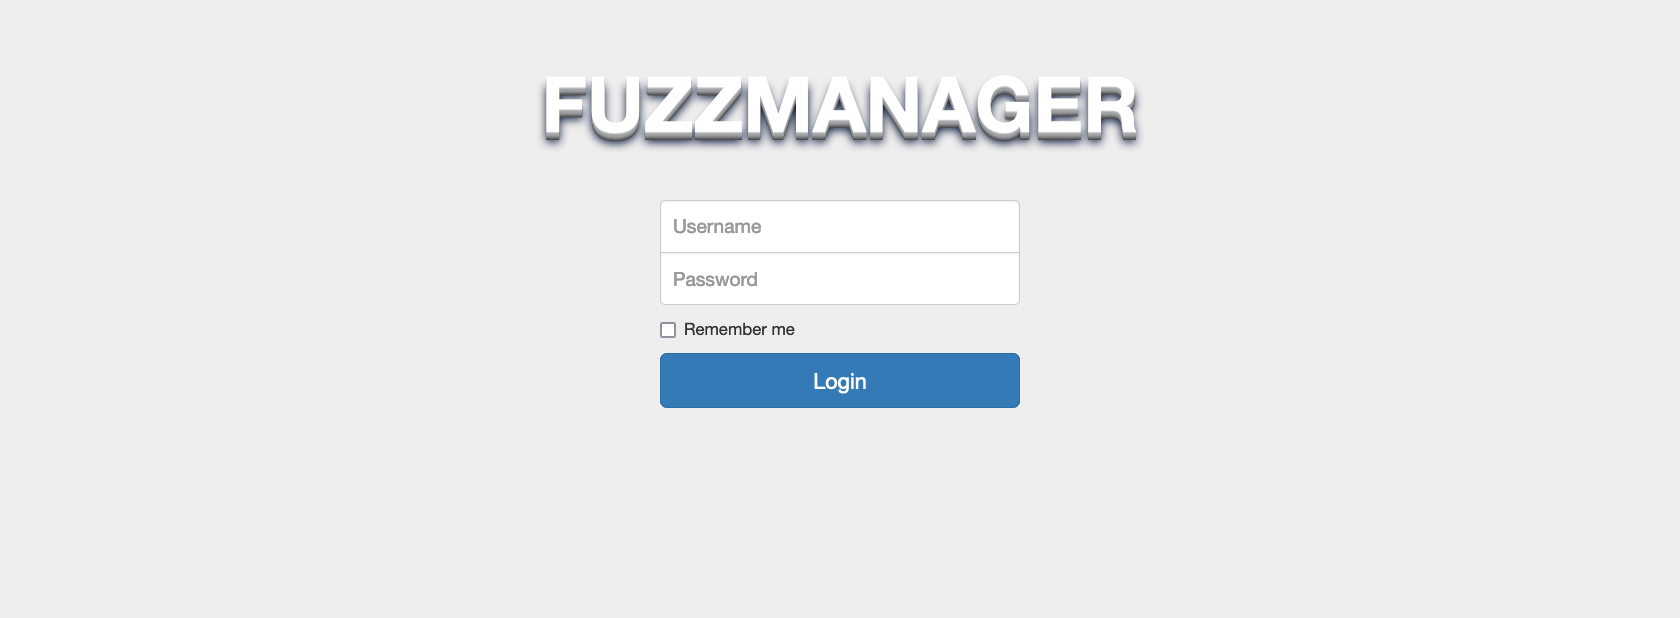

In [36]:
# ignore
Image(gui_driver.get_screenshot_as_png())

We now log in by sending `demo` both as username and password, and then click on the `Login` button.

In [37]:
# ignore
username = gui_driver.find_element_by_name("username")
username.send_keys("demo")

In [38]:
# ignore
password = gui_driver.find_element_by_name("password")
password.send_keys("demo")

In [39]:
# ignore
login = gui_driver.find_element_by_tag_name("button")
login.click()
time.sleep(1)

After login, we find an empty database.  This is where crashes will appear, once we have collected them.

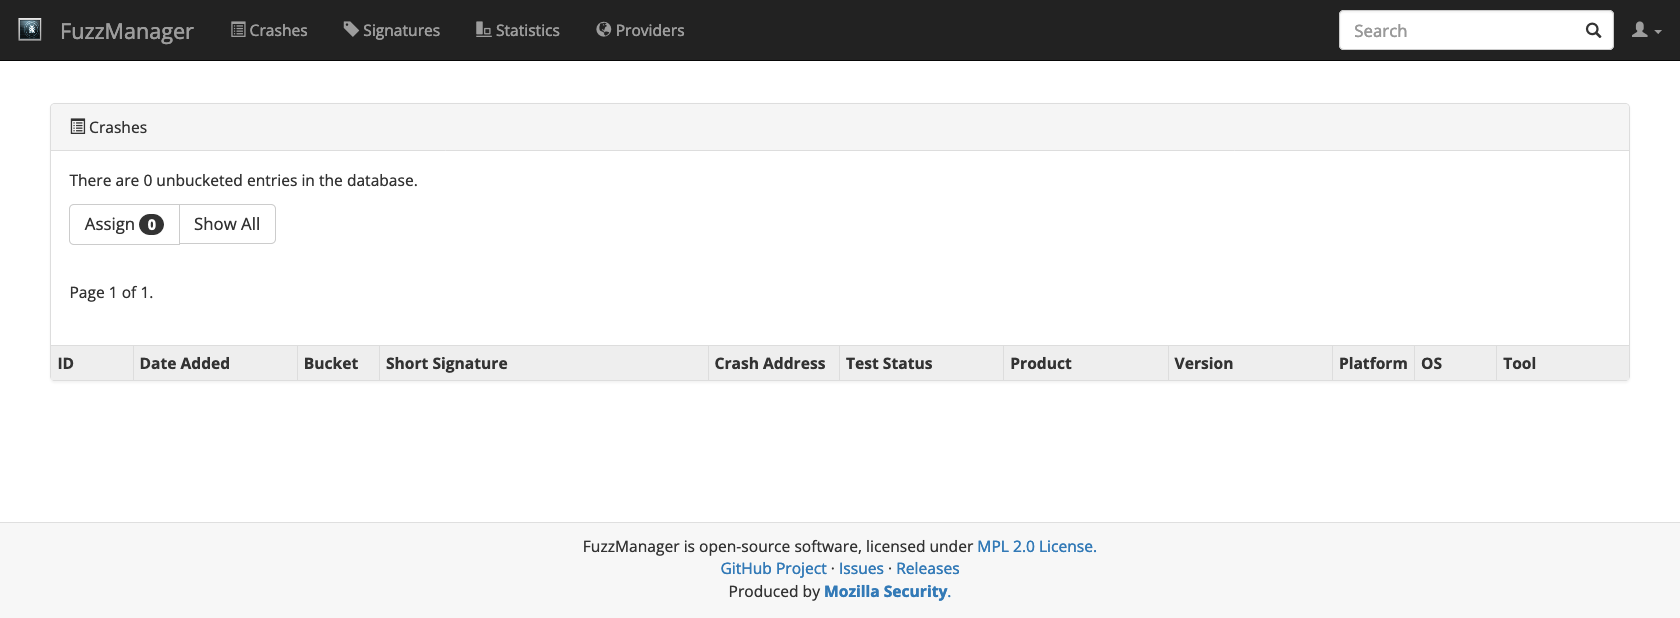

In [40]:
# ignore
Image(gui_driver.get_screenshot_as_png())

## Collecting Crashes

To fill our database, we need some crashes.  Let us take a look at `simply-buggy`, an example repository containing trivial C++ programs for illustration purposes.

In [41]:
!git clone https://github.com/choller/simply-buggy

Cloning into 'simply-buggy'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Receiving objects: 100% (22/22), 4.90 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (9/9), done.


The make command compiles our target program, including our first target, the *simple-crash* example. Alongside the program, there is also a configuration file generated.

In [42]:
!(cd simply-buggy && make)

clang++ -fsanitize=address -g -o maze maze.cpp
clang++ -fsanitize=address -g -o out-of-bounds out-of-bounds.cpp
clang++ -fsanitize=address -g -o simple-crash simple-crash.cpp


Let's take a look at the `simple-crash` source code in `simple-crash.cpp`.  As you can see, the source code is fairly simple: A forced crash by writing to a (near)-NULL pointer.  This should immediately crash on most machines.

In [43]:
# ignore
from bookutils import print_file

In [44]:
# ignore
print_file("simply-buggy/simple-crash.cpp")

/*
 * simple-crash - A simple NULL crash.
 *
 * WARNING: This program neither makes sense nor should you code like it is
 *          done in this program. It is purely for demo purposes and uses
 *          bad and meaningless coding habits on purpose.
 */

int crash() {
  int* p = (int*)0x1;
  *p = 0xDEADBEEF;
  return *p;
}

int main(int argc, char** argv) {
  return crash();
}

The configuration file `simple-crash.fuzzmanagerconf` generated for the the binary also contains some straightforward information, like the version of the program and other metadata that is required or at least useful later on when submitting crashes.

In [45]:
# ignore
print_file("simply-buggy/simple-crash.fuzzmanagerconf", lexer=IniLexer())

[Main]
platform = x86-64
product = simple-crash-simple-crash
product_version = 83038f74e812529d0fc172a718946fbec385403e
os = linux

[Metadata]
pathPrefix = /Users/zeller/Projects/fuzzingbook/notebooks/simply-buggy/
buildFlags = -fsanitize=address -g

Let us run the program!  We immediately get a crash trace as expected:

In [46]:
!simply-buggy/simple-crash

AddressSanitizer:DEADLYSIGNAL
==96626==ERROR: AddressSanitizer: SEGV on unknown address 0x000000000001 (pc 0x00010ae74eb8 bp 0x7ffee4d8deb0 sp 0x7ffee4d8de80 T0)
==96626==The signal is caused by a WRITE memory access.
==96626==Hint: address points to the zero page.
    #0 0x10ae74eb8 in crash() simple-crash.cpp:11
    #1 0x10ae74f3a in main simple-crash.cpp:16
    #2 0x7fff203adf3c in start+0x0 (libdyld.dylib:x86_64+0x15f3c)

==96626==Register values:
rax = 0x0000000000000001  rbx = 0x0000000000000000  rcx = 0x0000100000000000  rdx = 0x0000100000000000  
rdi = 0x0000000000000001  rsi = 0x00007ffee4d8de00  rbp = 0x00007ffee4d8deb0  rsp = 0x00007ffee4d8de80  
 r8 = 0x0000000000000000   r9 = 0x0000000000000000  r10 = 0x0000000000000000  r11 = 0x0000000000000000  
r12 = 0x0000000000000000  r13 = 0x0000000000000000  r14 = 0x0000000000000000  r15 = 0x0000000000000000  
AddressSanitizer can not provide additional info.
SUMMARY: AddressSanitizer: SEGV simple-crash.cpp:11 in crash()
==96626==AB

Now, what we would actually like to do is to run this binary from Python instead, detect that it crashed, collect the trace and submit it to the server. Let's start with a simple script that would just run the program we give it and detect the presence of the ASan trace:

In [47]:
import subprocess

In [48]:
cmd = ["simply-buggy/simple-crash"]

In [49]:
result = subprocess.run(cmd, stderr=subprocess.PIPE)
stderr = result.stderr.decode().splitlines()
crashed = False

for line in stderr:
    if "ERROR: AddressSanitizer" in line:
        crashed = True
        break

if crashed:
    print("Yay, we crashed!")
else:
    print("Move along, nothing to see...")

Yay, we crashed!


With this script, we can now run the binary and indeed detect that it crashed. But how do we send this information to the crash server now? Let's add a few features from the _FuzzManager_ toolbox.

### Program Configurations

A `ProgramConfiguration`  is largely a container class storing various properties of the program, e.g. product name, the platform, version and runtime options.  By default, it reads the information from the `.fuzzmanagerconf` file created for the program under test.

In [50]:
sys.path.append('FuzzManager')

In [51]:
from FTB.ProgramConfiguration import ProgramConfiguration  # type: ignore

In [52]:
configuration = ProgramConfiguration.fromBinary('simply-buggy/simple-crash')
(configuration.product, configuration.platform)

('simple-crash-simple-crash', 'x86-64')

### Crash Info

A `CrashInfo` object stores all the necessary data about a crash, including 

* the stdout output of your program
* the stderr output of your program
* crash information as produced by GDB or AddressSanitizer
* a `ProgramConfiguration` instance

In [53]:
from FTB.Signatures.CrashInfo import CrashInfo  # type: ignore

Let's collect the information for the run of `simply-crash`:

In [54]:
cmd = ["simply-buggy/simple-crash"]
result = subprocess.run(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE)

In [55]:
stderr = result.stderr.decode().splitlines()
stderr[0:3]

['AddressSanitizer:DEADLYSIGNAL',
 '=================================================================',
 '==96631==ERROR: AddressSanitizer: SEGV on unknown address 0x000000000001 (pc 0x00010388aeb8 bp 0x7ffeec377f40 sp 0x7ffeec377f10 T0)']

In [56]:
stdout = result.stdout.decode().splitlines()
stdout

[]

This reads and parses our ASan trace into a more generic format, returning us a generic `CrashInfo` object that we can inspect and/or submit to the server:

In [57]:
crashInfo = CrashInfo.fromRawCrashData(stdout, stderr, configuration)
print(crashInfo)

Crash trace:

# 00    crash
# 01    main
# 02    start+0x0

Crash address: 0x1

Last 5 lines on stderr:
 r8 = 0x0000000000000000   r9 = 0x0000000000000000  r10 = 0x0000000000000000  r11 = 0x0000000000000000  
r12 = 0x0000000000000000  r13 = 0x0000000000000000  r14 = 0x0000000000000000  r15 = 0x0000000000000000  
AddressSanitizer can not provide additional info.
SUMMARY: AddressSanitizer: SEGV simple-crash.cpp:11 in crash()
==96631==ABORTING


### Collector

The last step is to send the crash info to our crash manager.  A `Collector` is a feature to communicate with a CrashManager server. Collector provides an easy client interface that allows your clients to submit crashes as well as download and match existing signatures to avoid reporting frequent issues repeatedly.

In [58]:
from Collector.Collector import Collector  # type: ignore

We instantiate the collector instance; this will be our entry point for talking to the server.

In [59]:
collector = Collector()

To submit the crash info, we use the collector's `submit()` method:

In [60]:
collector.submit(crashInfo)

{'rawStdout': '',
 'rawStderr': 'AddressSanitizer:DEADLYSIGNAL\n=================================================================\n==96631==ERROR: AddressSanitizer: SEGV on unknown address 0x000000000001 (pc 0x00010388aeb8 bp 0x7ffeec377f40 sp 0x7ffeec377f10 T0)\n==96631==The signal is caused by a WRITE memory access.\n==96631==Hint: address points to the zero page.\n    #0 0x10388aeb8 in crash() simple-crash.cpp:11\n    #1 0x10388af3a in main simple-crash.cpp:16\n    #2 0x7fff203adf3c in start+0x0 (libdyld.dylib:x86_64+0x15f3c)\n\n==96631==Register values:\nrax = 0x0000000000000001  rbx = 0x0000000000000000  rcx = 0x0000100000000000  rdx = 0x0000100000000000  \nrdi = 0x0000000000000001  rsi = 0x00007ffeec377f00  rbp = 0x00007ffeec377f40  rsp = 0x00007ffeec377f10  \n r8 = 0x0000000000000000   r9 = 0x0000000000000000  r10 = 0x0000000000000000  r11 = 0x0000000000000000  \nr12 = 0x0000000000000000  r13 = 0x0000000000000000  r14 = 0x0000000000000000  r15 = 0x0000000000000000  \nAddressSani

### Inspecting Crashes

We now submitted something to our local FuzzManager demo instance.  If you run the crash server on your local machine, you can go to http://127.0.0.1:8000/crashmanager/crashes/ you should see the crash info just submitted.  You can inquire the product, version, operating system, and further crash details.

In [61]:
# ignore
gui_driver.refresh()

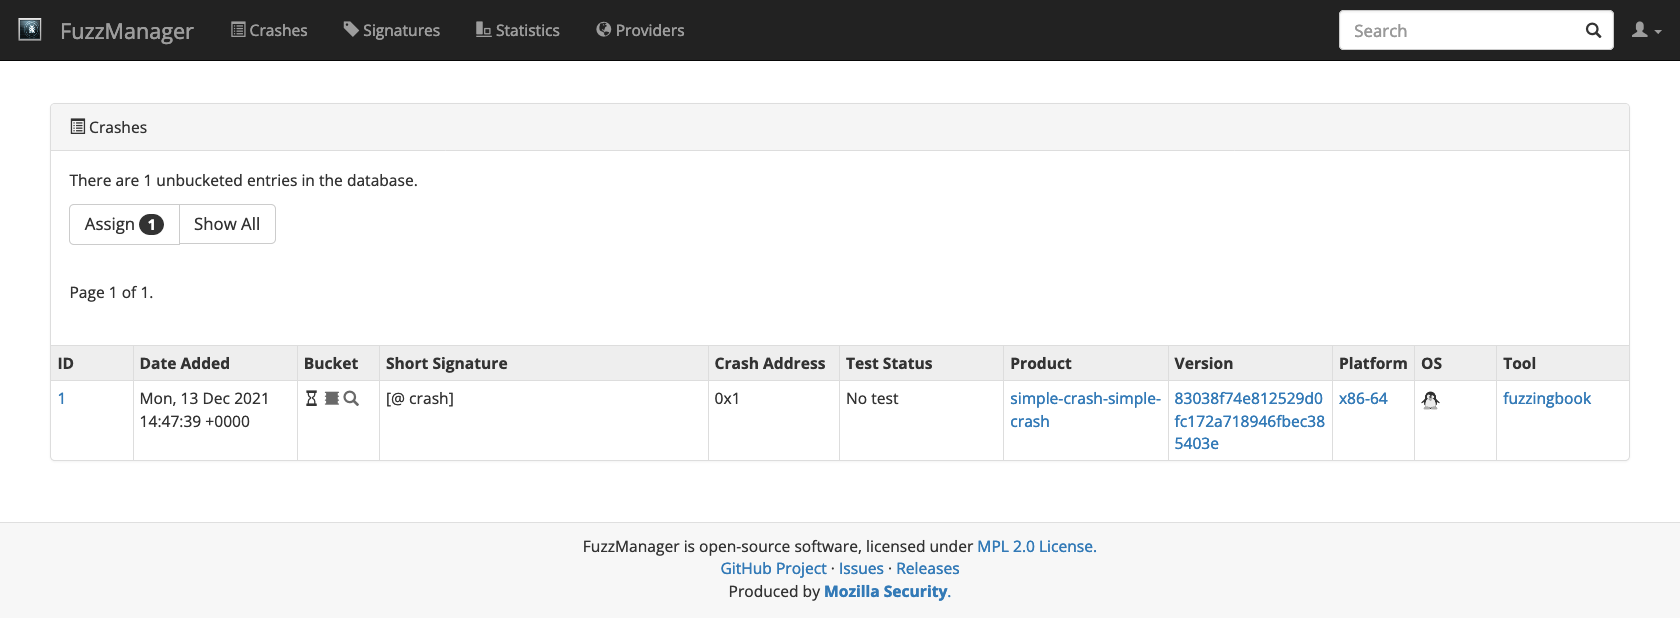

In [62]:
# ignore
Image(gui_driver.get_screenshot_as_png())

If you click on the crash ID, you can further inspect the submitted data.

In [63]:
# ignore
crash = gui_driver.find_element_by_xpath('//td/a[contains(@href,"/crashmanager/crashes/")]')
crash.click()
time.sleep(1)

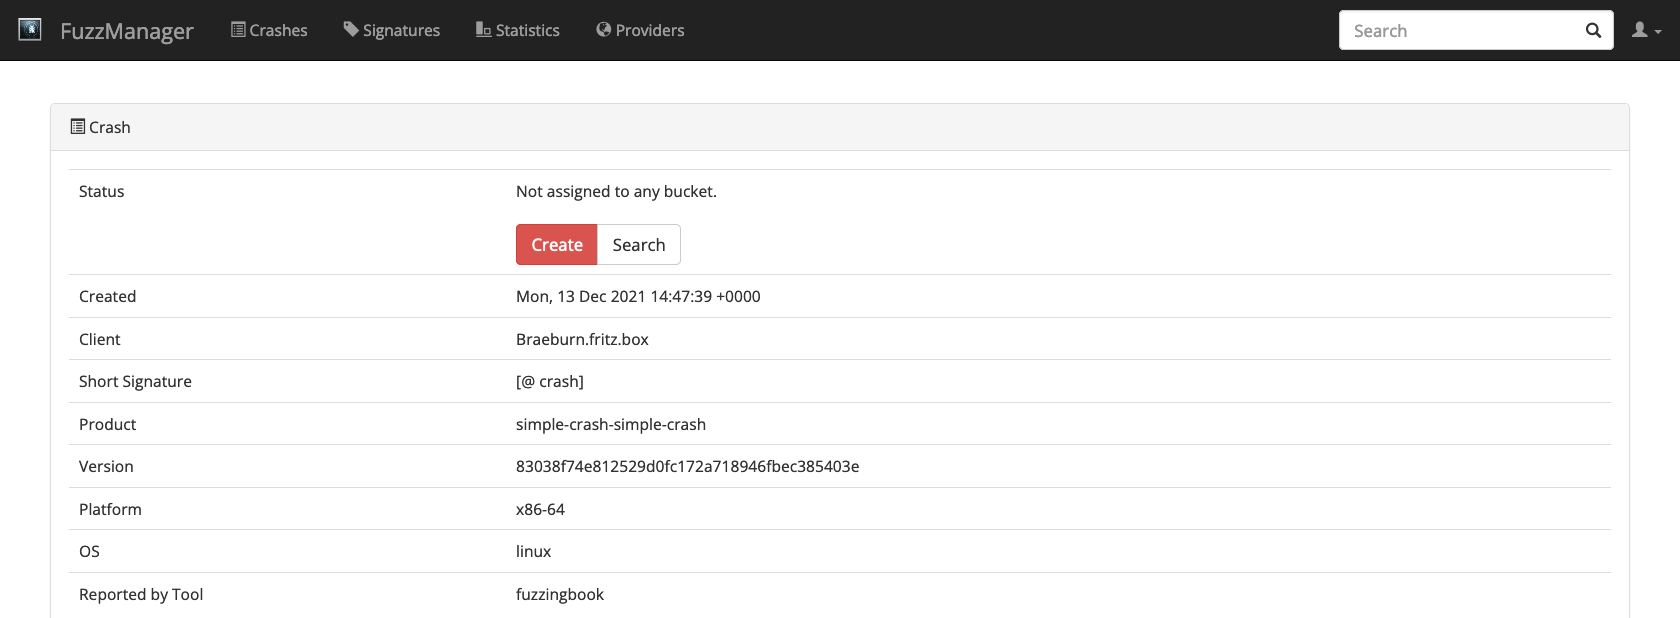

In [64]:
# ignore
Image(gui_driver.get_screenshot_as_png())

Since `Collector`s can be called from any program (provided they are configured to talk to the correct server), you can now collect crashes from anywhere – fuzzers on remote machines, crashes occurring during beta testing, or even crashes during production.

## Crash Buckets

One challenge with collecting crashes is that the _same crashes occur multiple times._  If a product is in the hands of millions of users, chances are that thousands of them will encounter the same bug, and thus the same crash.  Therefore, the database will have thousands of entries that are all caused by the same one bug.  Therefore, it is necessary to identify those failures that are _similar_ and to group them together in a set called a _crash bucket_ or _bucket_ for short.

In _FuzzManager_, a bucket is defined through a _crash signature_, a list of predicates matching a set of bugs.  Such a predicate can refer to a number of features, the most important being

* the current _program counter_, reporting the instruction excuted at the moment of the crash;
* elements from the _stack trace_, showing which functions were active at the moment of the crash.

We can create such a signature right away when viewing a single crash:

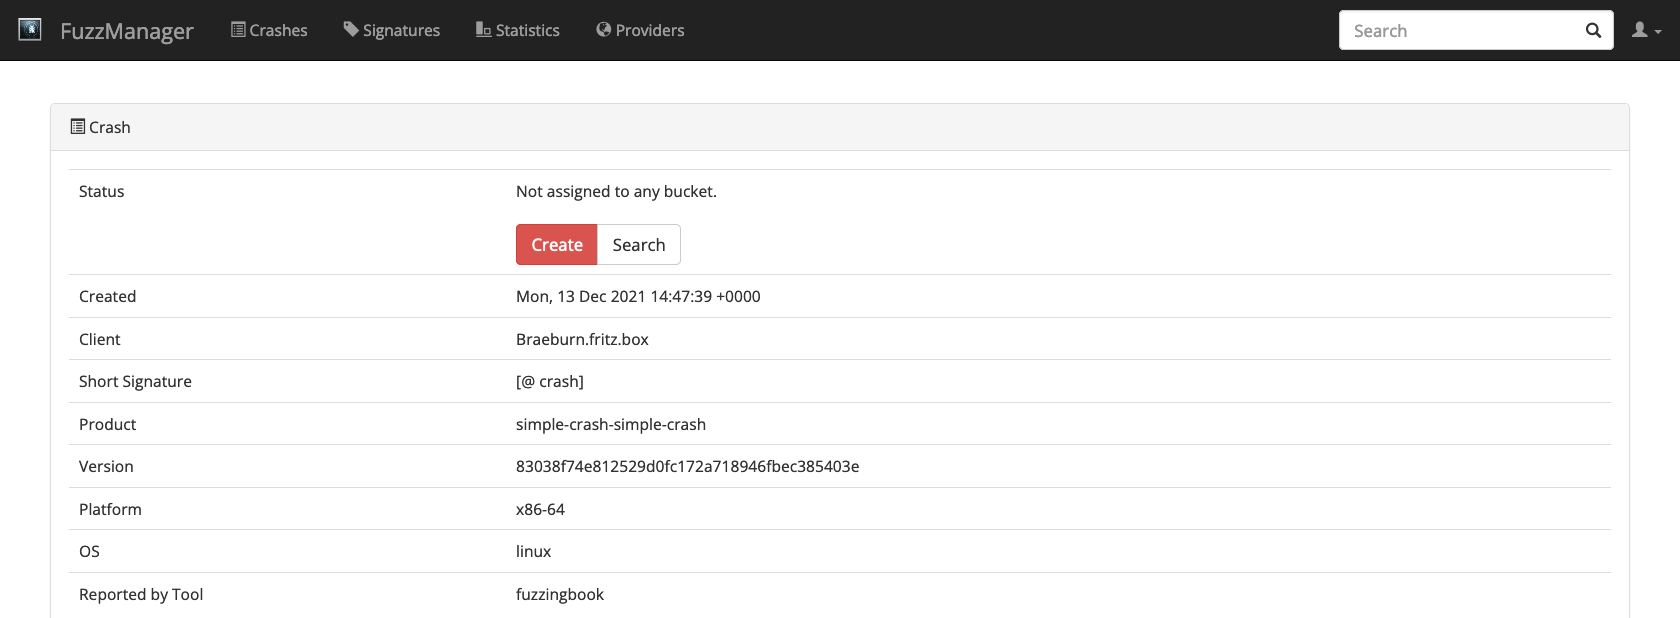

In [65]:
# ignore
Image(gui_driver.get_screenshot_as_png())

Clicking the red `Create` button creates a bucket for this crash.  A _crash signature_ will be proposed to you for matching this and future crashes of the same type:

In [66]:
# ignore
create = gui_driver.find_element_by_xpath('//a[contains(@href,"/signatures/new/")]')
create.click()
time.sleep(1)

In [67]:
# ignore
gui_driver.set_window_size(1400, 1200)

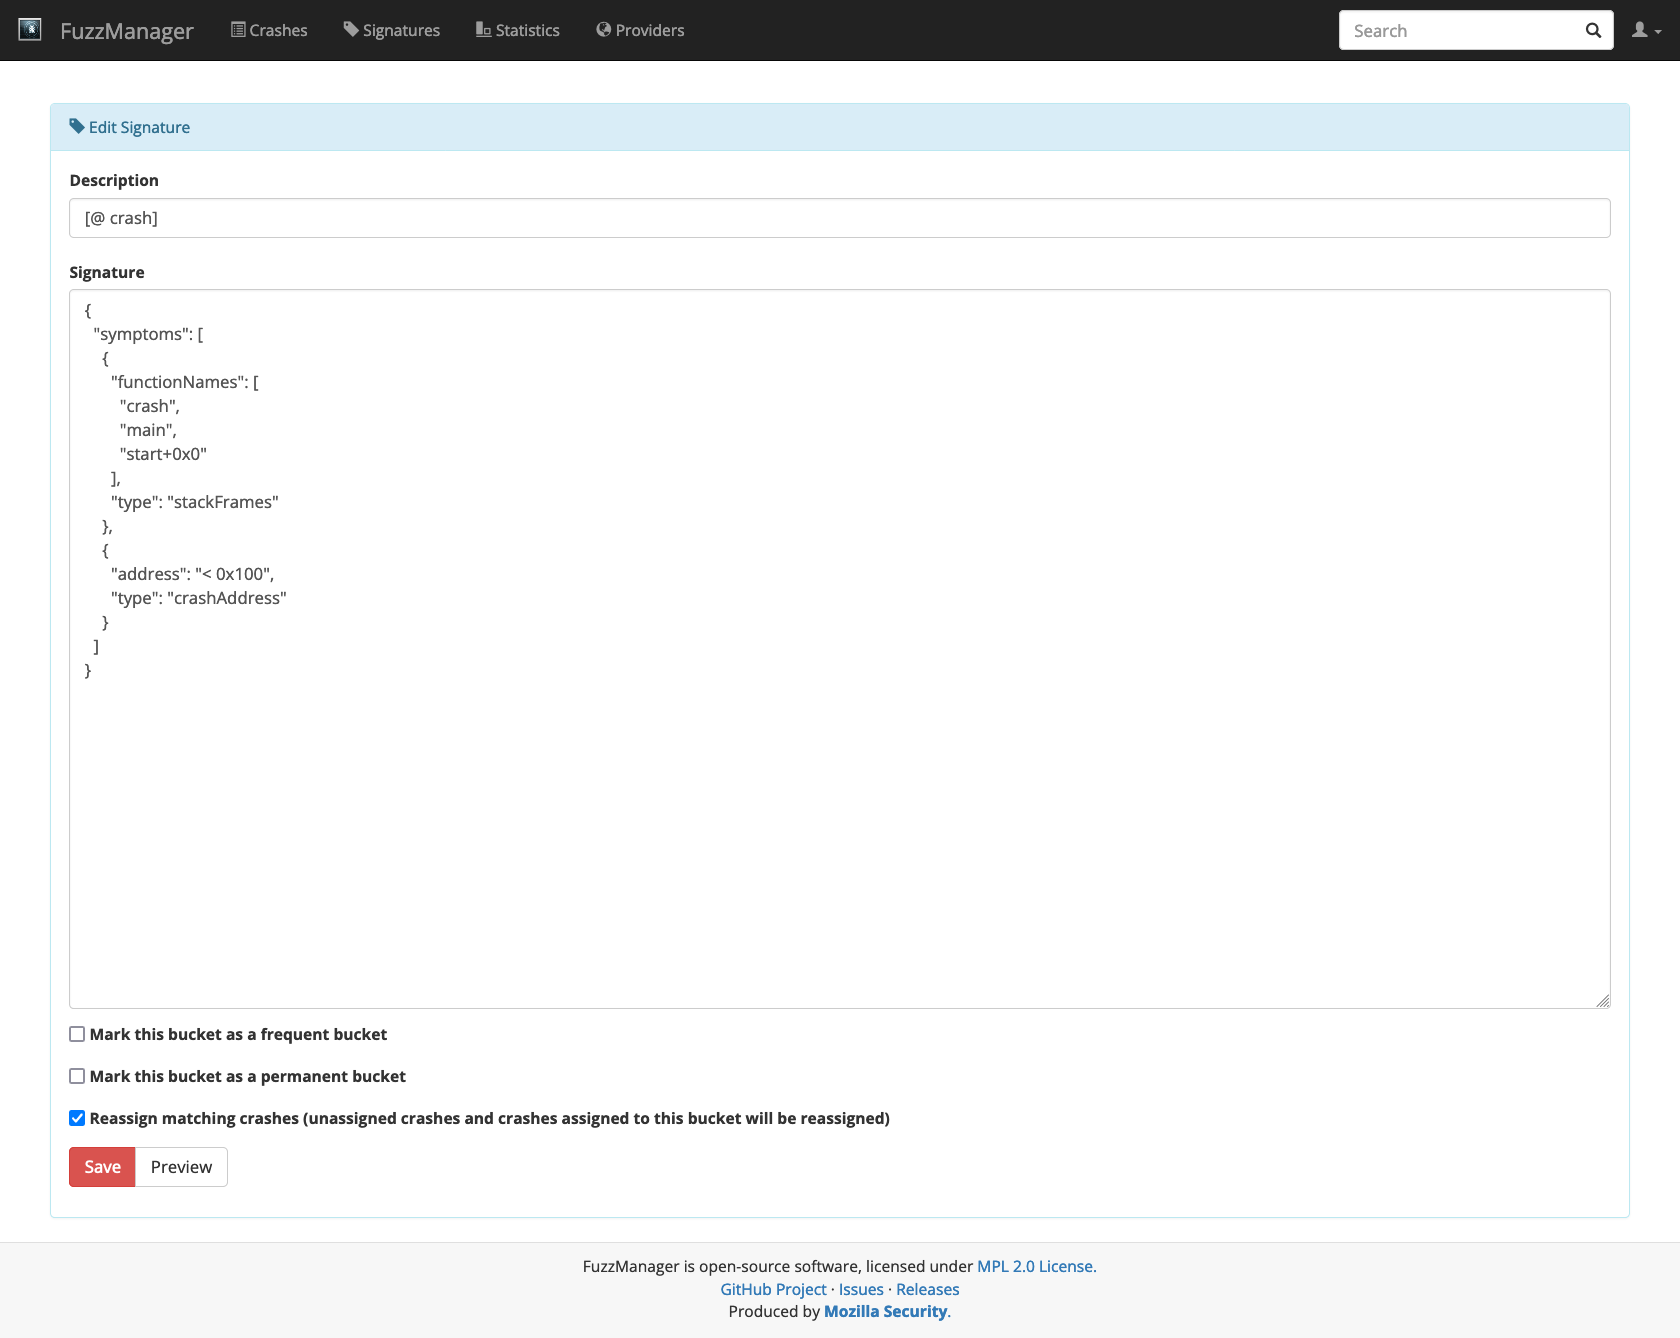

In [68]:
# ignore
Image(gui_driver.get_screenshot_as_png())

Accept it by clicking *Save*.

In [69]:
# ignore
save = gui_driver.find_element_by_name("submit_save")
save.click()
time.sleep(1)

You will be redirected to the newly created bucket, which shows you the size (how many crashes it holds), its bug report status (buckets can be linked to bugs in an external bug tracker like Bugzilla) and many other useful information.

### Crash Signatures

If you click on the *Signatures* entry in the top menu, you should also see your newly created entry.

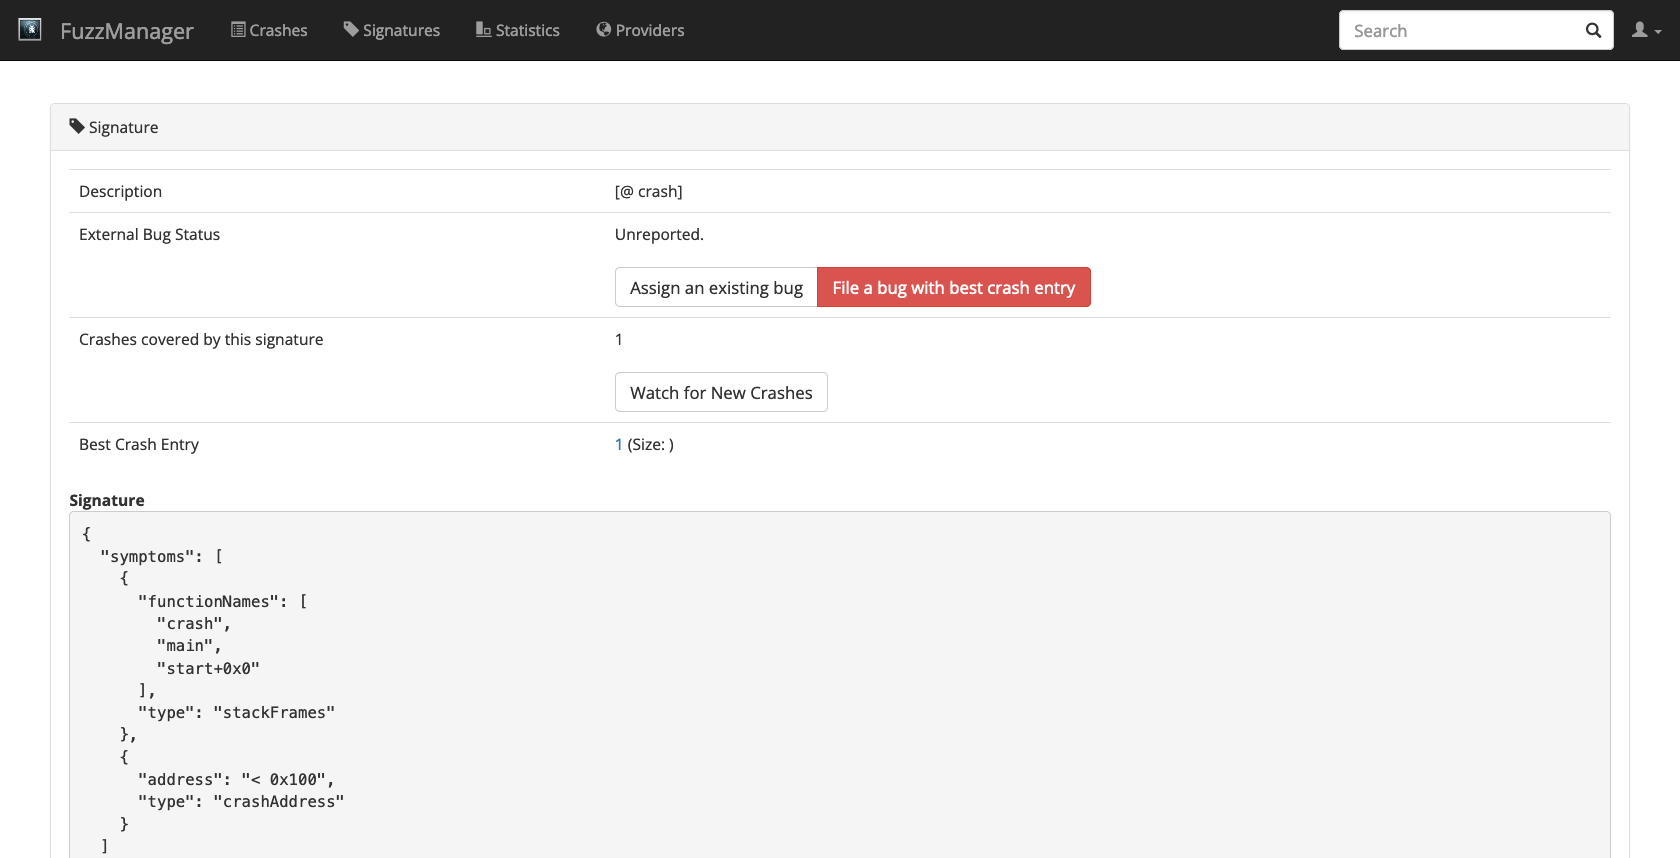

In [70]:
# ignore
gui_driver.set_window_size(1400, 800)
Image(gui_driver.get_screenshot_as_png())

You see that this signature refers to a crash occurring in the function `crash()` (duh!) when called from `main()` when called from `start()` (an internal OS function).  We also see the current crash address.

Buckets and their signatures are a central concept in FuzzManager. If you receive a lot of crash reports from various sources, bucketing allows you to easily group crashes and filter duplicates.

### Coarse-Grained Signatures

The flexible signature system starts out with an initially proposed fine-grained signature, but it can be adjusted as needed to capture _variations_ of the same bug and make tracking easier.

In the next example, we will look at a more complex example that reads data from a file and creates multiple crash signatures - a file `out-of-bounds.cpp`:

In [71]:
# ignore
print_file("simply-buggy/out-of-bounds.cpp")

/*
 * out-of-bounds - A simple multi-signature out-of-bounds demo.
 *
 * WARNING: This program neither makes sense nor should you code like it is
 *          done in this program. It is purely for demo purposes and uses
 *          bad and meaningless coding habits on purpose.
 */
#include <cstring>
#include <fstream>
#include <iostream>

void printFirst(char* data, size_t count) {
  std::string first(data, count);
  std::cout << first << std::endl;
}

void printLast(char* data, size_t count) {
  std::string last(data + strlen(data) - count, count);
  std::cout << last << std::endl;
}

int validateAndPerformAction(char* buffer, size_t size) {
  if (size < 2) {
    std::cerr << "Buffer is too short." << std::endl;
    return 1;
  }

  uint8_t action = buffer[0];
  uint8_t count = buffer[1];
  char* data = buffer + 2;

  if (!count) {
    std::cerr << "count must be non-zero." << std::endl;
    return 1;
  }

  // Forgot to check count vs. the length of data here, doh!

  if (!action) {


This program looks way more elaborate compared to the last one, but don't worry, it is not really doing a whole lot:

* The code in the `main()` function simply reads a file provided on the command line and puts its contents into a buffer that is passed to `validateAndPerformAction()`. 

* That `validateAndPerformAction()` function pulls out two bytes of the buffer (`action` and `count`) and considers the rest `data`. Depending on the value of `action`, it then calls either `printFirst()` or `printLast()`, which prints either the first or the last `count` bytes of `data`. 

If this sounds pointless, that is because it is.  The whole idea of this program is that the security check (that `count` is not larger than the length of `data`) is missing in `validateAndPerformAction()` but that the illegal access happens later in either of the two print functions. Hence, we would expect this program to generate at least two (slightly) different crash signatures - one with `printFirst()` and one with `printLast()`.

Let's try it out with very simple fuzzing based on the last Python script.

In [72]:
# ignore
import os
import random
import subprocess
import tempfile
import sys

Since _FuzzManager_ can have trouble with 8-bit characters in the input, we introduce an `escapelines()` function that converts text to printable ASCII characters.

#### Excursion: `escapelines()` implementatipn

In [73]:
def isascii(s):
    return all([0 <= ord(c) <= 127 for c in s])

In [74]:
isascii('Hello,')

True

In [75]:
def escapelines(bytes):
    def ascii_chr(byte):
        if 0 <= byte <= 127:
            return chr(byte)
        return r"\x%02x" % byte

    def unicode_escape(line):
        ret = "".join(map(ascii_chr, line))
        assert isascii(ret)
        return ret

    return [unicode_escape(line) for line in bytes.splitlines()]

In [76]:
escapelines(b"Hello,\nworld!")

['Hello,', 'world!']

In [77]:
escapelines(b"abc\xffABC")

['abc\\xffABC']

#### End of Excursion

Now to the actual script.  As above, we set up a collector that collects and sends crash info whenever a crash occurs.

In [78]:
cmd = ["simply-buggy/out-of-bounds"]

# Connect to crash server
collector = Collector()

random.seed(2048)

crash_count = 0
TRIALS = 20

for itnum in range(0, TRIALS):
    rand_len = random.randint(1, 1024)
    rand_data = bytes([random.randrange(0, 256) for i in range(rand_len)])

    (fd, current_file) = tempfile.mkstemp(prefix="fuzztest", text=True)
    os.write(fd, rand_data)
    os.close(fd)

    current_cmd = []
    current_cmd.extend(cmd)
    current_cmd.append(current_file)

    result = subprocess.run(current_cmd,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE)
    stdout = []   # escapelines(result.stdout)
    stderr = escapelines(result.stderr)
    crashed = False

    for line in stderr:
        if "ERROR: AddressSanitizer" in line:
            crashed = True
            break

    print(itnum, end=" ")

    if crashed:
        sys.stdout.write("(Crash) ")

        # This reads the simple-crash.fuzzmanagerconf file
        configuration = ProgramConfiguration.fromBinary(cmd[0])

        # This reads and parses our ASan trace into a more generic format,
        # returning us a generic "CrashInfo" object that we can inspect
        # and/or submit to the server.
        crashInfo = CrashInfo.fromRawCrashData(stdout, stderr, configuration)

        # Submit the crash
        collector.submit(crashInfo, testCase = current_file)

        crash_count += 1

    os.remove(current_file)

print("")
print("Done, submitted %d crashes after %d runs." % (crash_count, TRIALS))

0 (Crash) 1 2 (Crash) 3 4 5 6 7 8 (Crash) 9 10 11 12 (Crash) 13 14 (Crash) 15 16 17 18 19 
Done, submitted 5 crashes after 20 runs.


If you run this script, you will see its progress and notice that it produces quite a few crashes. And indeed, if you visit the [FuzzManager crashes page](http://127.0.0.1:8000/crashmanager/crashes/), you will notice a variety of crashes that have accumulated:

In [79]:
# ignore
gui_driver.get(fuzzmanager_url + "/crashmanager/crashes")

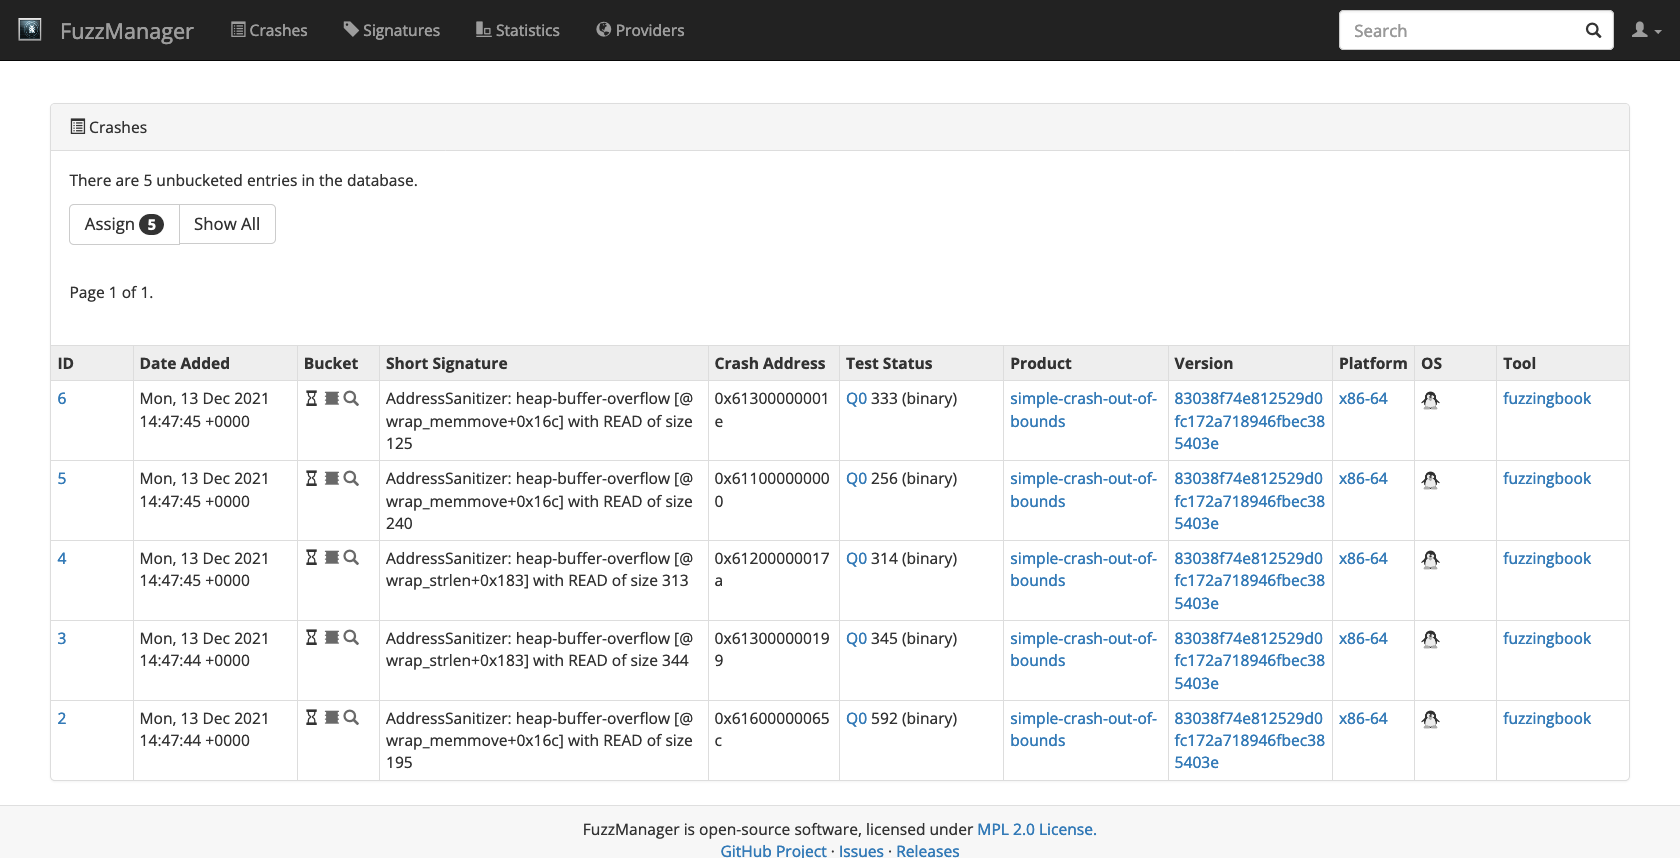

In [80]:
# ignore
Image(gui_driver.get_screenshot_as_png())

Pick the first crash and create a bucket for it, like you did the last time. After saving, you will notice that not all of your crashes went into the bucket. The reason is that our program created several different stacks that are somewhat similar but not exactly identical. This is a common problem when fuzzing real world applications.

Fortunately, there is an easy way to deal with this. While on the bucket page, hit the *Optimize* button for the bucket. FuzzManager will then automatically propose you to change your signature. Accept the change by hitting `Edit with Changes` and then `Save`. Repeat these steps until all crashes are part of the bucket. After 3 to 4 iterations, your signature will likely look like this:

```json
{
  "symptoms": [
    {
      "type": "output",
      "src": "stderr",
      "value": "/ERROR: AddressSanitizer: heap-buffer-overflow/"
    },
    {
      "type": "stackFrames",
      "functionNames": [
        "?",
        "?",
        "?",
        "validateAndPerformAction",
        "main",
        "__libc_start_main",
        "_start"
      ]
    },
    {
      "type": "crashAddress",
      "address": "> 0xFF"
    }
  ]
}
```

As you can see in the `stackFrames` signature symptom, the `validateAndPerformAction` function is still present in the stack frame, because this function is common across all stack traces in all crashes; in fact, this is where the bug lives.  But the lower stack parts have been generalized into arbitrary functions (`?`) because they vary across the set of submitted crashes.

The `Optimize` function is designed to automate this process as much as possible: It attempts to broaden the signature by fitting it to untriaged crashes and then checks if the modified signature would touch other existing buckets. This works with the assumption that other buckets are indeed other bugs, i.e. if you had created two buckets from your crashes first, optimizing would not work anymore. Also, if the existing bucket data is sparse and you have a lot of untriaged crashes, the algorithm could propose changes that include crashes of different bugs in the same bucket. There is no way to fully automatically detect and prevent this, hence the process is semi-automated and requires you to review all proposed changes.

## Collecting Code Coverage

In the [chapter on coverage](Coverage.ipynb), we have seen how measuring code coverage can be beneficial to assess fuzzer performance.  Holes in code coverage can reveal particularly hard-to-reach locations as well as bugs in the fuzzer itself.  Because this is an important part of the overall fuzzing operations, FuzzManager supports visualizing _per-fuzzing code coverage_ of repositories – that is, we can interactively _inspect_ which code was covered during fuzzing, and which was not.

To illustrate coverage collection and visualization in _FuzzManager_, we take a look at a another simple C++ program, the `maze.cpp` example:

In [81]:
# ignore
print_file("simply-buggy/maze.cpp")

/*
 * maze - A simple constant maze that crashes at some point.
 *
 * WARNING: This program neither makes sense nor should you code like it is
 *          done in this program. It is purely for demo purposes and uses
 *          bad and meaningless coding habits on purpose.
 */

#include <cstdlib>
#include <iostream>

int boom() {
  int* p = (int*)0x1;
  *p = 0xDEADBEEF;
  return *p;
}

int main(int argc, char** argv) {
  if (argc != 5) {
    std::cerr << "All I'm asking for is four numbers..." << std::endl;
    return 1;
  }

  int num1 = atoi(argv[1]);
  if (num1 > 0) {
    int num2 = atoi(argv[2]);
    if (num1 > 2040109464) {
      if (num2 < 0) {
        std::cerr << "You found secret 1" << std::endl;
        return 0;
      }
    } else {
      if ((unsigned int)num2 == 3735928559) {
        unsigned int num3 = atoi(argv[3]);
        if (num3 == 3405695742) {
          int num4 = atoi(argv[4]);
          if (num4 == 1111638594) {
            std::cerr << "You found secret 2" << s

As you can see, all this program does is read some numbers from the command line, compare them to some magical constants and arbitrary criteria, and if everything works out, you reach one of the two secrets in the program.  Reaching one of these secrets also triggers a failure.

Before we start to work on this program, we recompile the programs with coverage support. In order to emit code coverage with either Clang or GCC, programs typically need to be built and linked with special `CFLAGS` like `--coverage`. In our case, the Makefile does this for us:

In [82]:
!(cd simply-buggy && make clean && make coverage)

rm -f ./maze ./out-of-bounds ./simple-crash
clang++ -fsanitize=address -g --coverage -o maze maze.cpp
clang++ -fsanitize=address -g --coverage -o out-of-bounds out-of-bounds.cpp
clang++ -fsanitize=address -g --coverage -o simple-crash simple-crash.cpp


Also, if we want to use FuzzManager to look at our code, we need to do the initial repository setup (essentially giving the server its own working copy of our _git_ repository to pull the source from). Normally, the client and server run on different machines, so this involves checking out the repository on the server and telling it where to find it (and what version control system it uses):

In [83]:
!git clone https://github.com/choller/simply-buggy $HOME/simply-buggy-server    

Cloning into '/Users/zeller/simply-buggy-server'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Receiving objects: 100% (22/22), 4.90 KiB | 4.90 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [84]:
!cd FuzzManager; python3 server/manage.py setup_repository simply-buggy GITSourceCodeProvider $HOME/simply-buggy-server

Successfully created repository 'simply-buggy' with provider 'GITSourceCodeProvider' located at /Users/zeller/simply-buggy-server


We now assume that we know some of the magic constants (like in practice, we sometimes know some things about the target, but might miss a detail) and we fuzz the program with that:

In [85]:
import random
import subprocess

In [86]:
random.seed(0)
cmd = ["simply-buggy/maze"]

constants = [3735928559, 1111638594]

TRIALS = 1000

for itnum in range(0, TRIALS):
    current_cmd = []
    current_cmd.extend(cmd)

    for _ in range(0, 4):
        if random.randint(0, 9) < 3:
            current_cmd.append(str(constants[
                random.randint(0, len(constants) - 1)]))
        else:
            current_cmd.append(str(random.randint(-2147483647, 2147483647)))

    result = subprocess.run(current_cmd, stderr=subprocess.PIPE)
    stderr = result.stderr.decode().splitlines()
    crashed = False

    if stderr and "secret" in stderr[0]:
        print(stderr[0])

    for line in stderr:
        if "ERROR: AddressSanitizer" in line:
            crashed = True
            break

    if crashed:
        print("Found the bug!")
        break

print("Done!")

You found secret 1
You found secret 1
You found secret 1
You found secret 1
You found secret 1
Done!


As you can see, with 1000 runs we found secret 1 a few times, but secret 2 (and the crash) are still missing. In order to determine how to improve this, we are now going to look at the _coverage data._

We use Mozilla's `grcov` tool to capture graphical coverage information.

In [87]:
!export PATH=$HOME/.cargo/bin:$PATH; grcov simply-buggy/ -t coveralls+ --commit-sha $(cd simply-buggy && git rev-parse HEAD) --token NONE -p `pwd`/simply-buggy/ > coverage.json

In [88]:
!cd FuzzManager; python3 -mCovReporter --repository simply-buggy --description "Test1" --submit ../coverage.json

We can now go to the [FuzzManager coverage page](http://127.0.0.1:8000/covmanager/) to take a look at our source code and its coverage.

In [89]:
# ignore
gui_driver.get(fuzzmanager_url + "/covmanager")

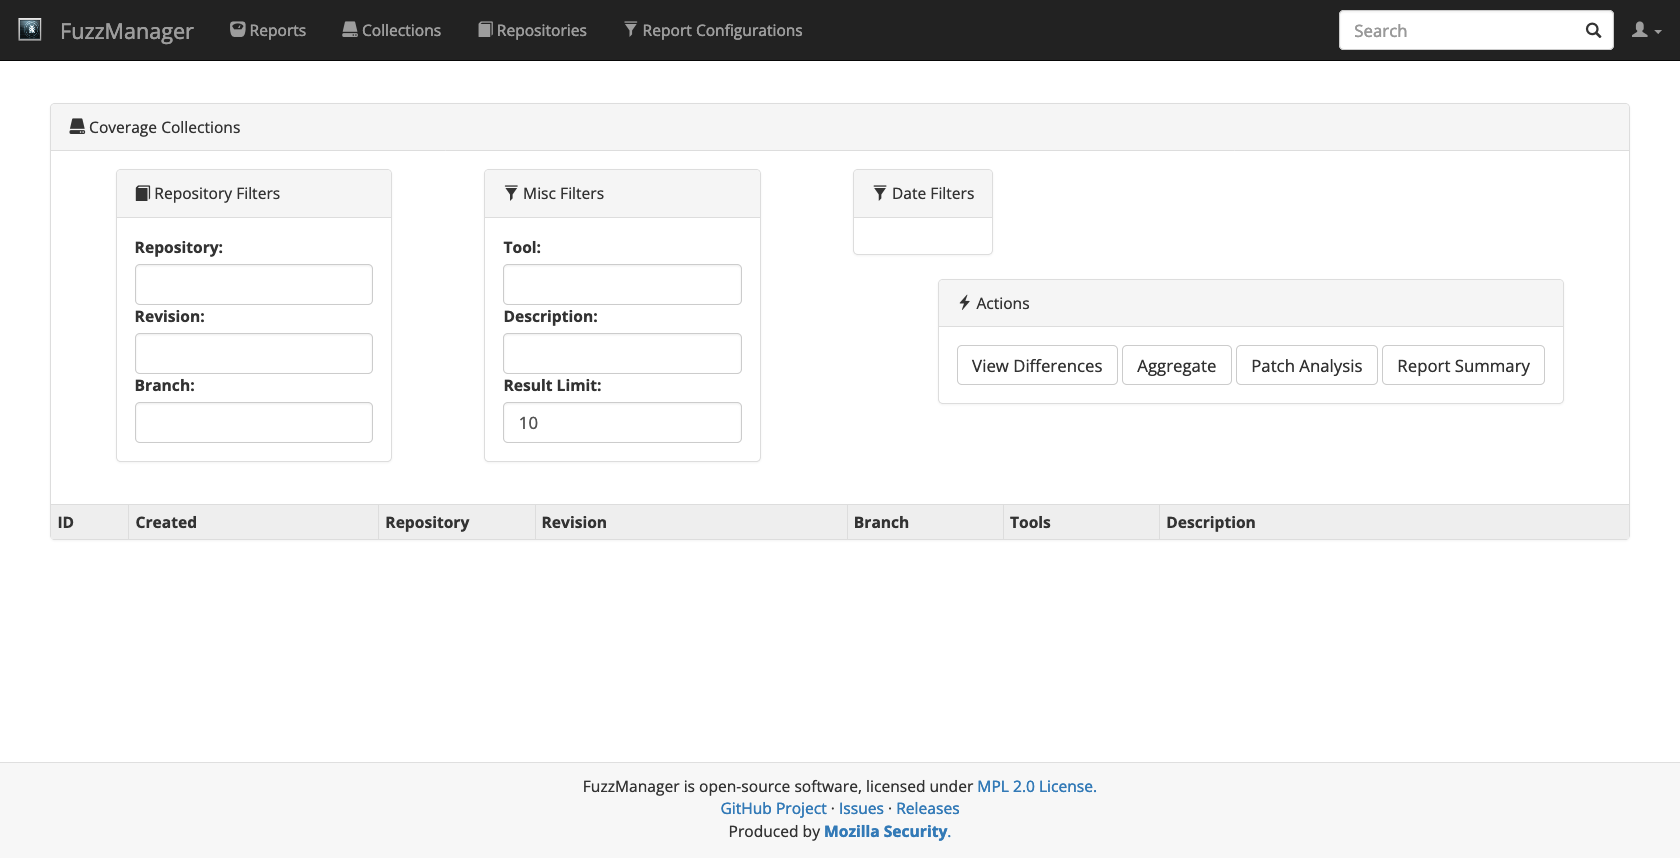

In [90]:
# ignore
Image(gui_driver.get_screenshot_as_png())

Click on the first ID to browse the coverage data that you just submitted.

In [91]:
# ignore
first_id = gui_driver.find_element_by_xpath('//td/a[contains(@href,"/browse")]')
first_id.click()
time.sleep(1)

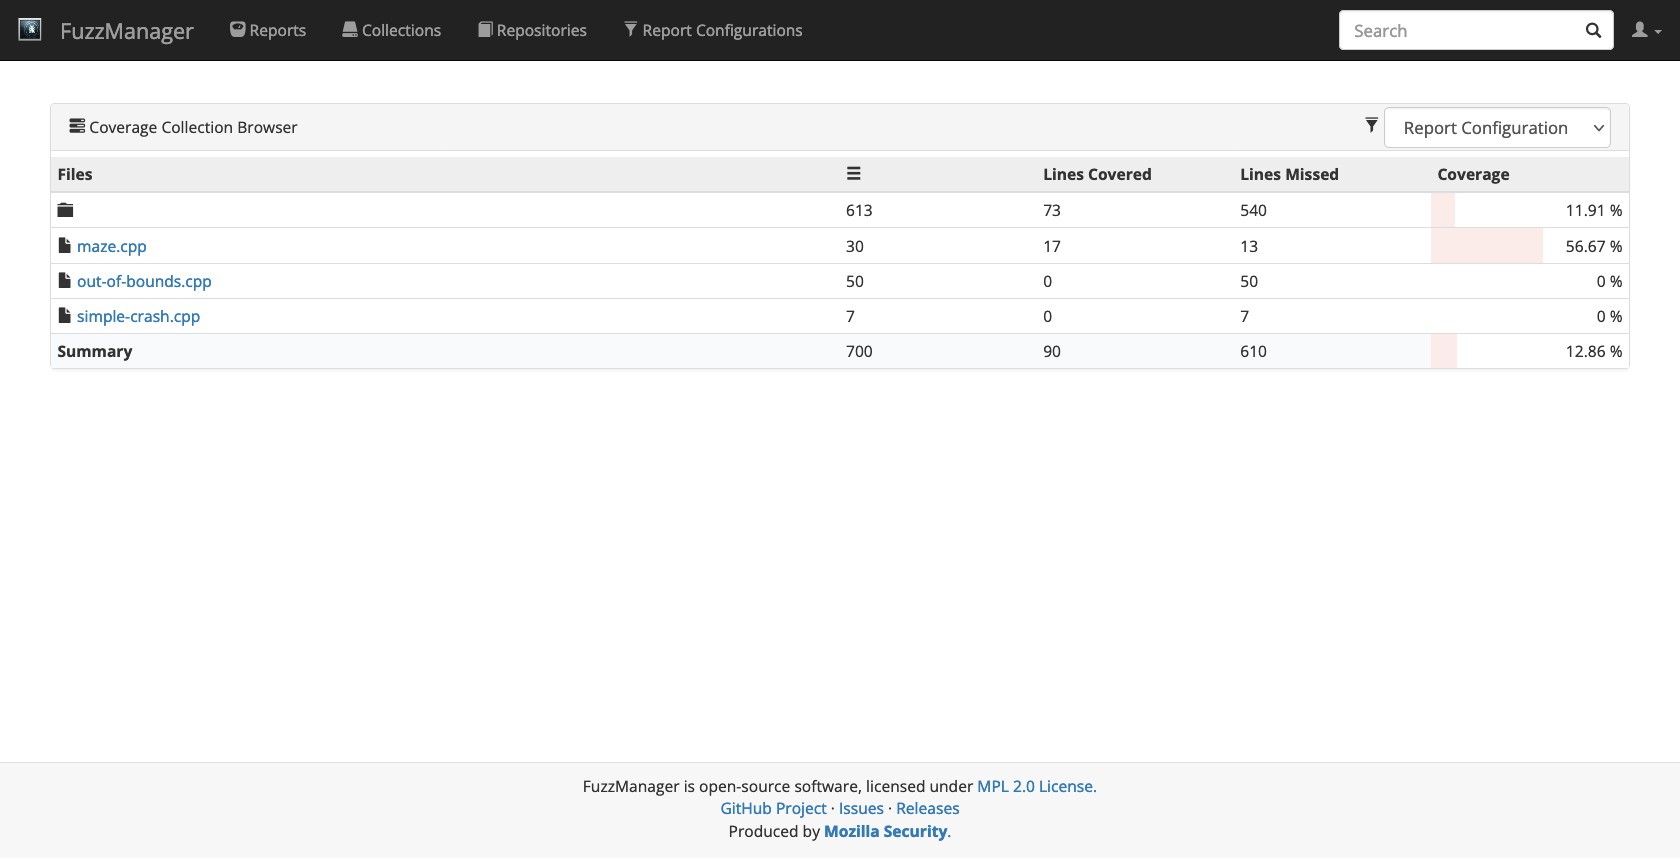

In [92]:
# ignore
Image(gui_driver.get_screenshot_as_png())

You will first see the full list of files in the `simply-buggy` repository, with all but the `maze.cpp` file showing 0% coverage (because we didn't do anything with these binaries since we rebuilt them with coverage support). Now click on `maze.cpp` and inspect the coverage line by line:

In [93]:
# ignore
maze_cpp = gui_driver.find_element_by_xpath("//*[contains(text(), 'maze.cpp')]")
maze_cpp.click()
time.sleep(1)

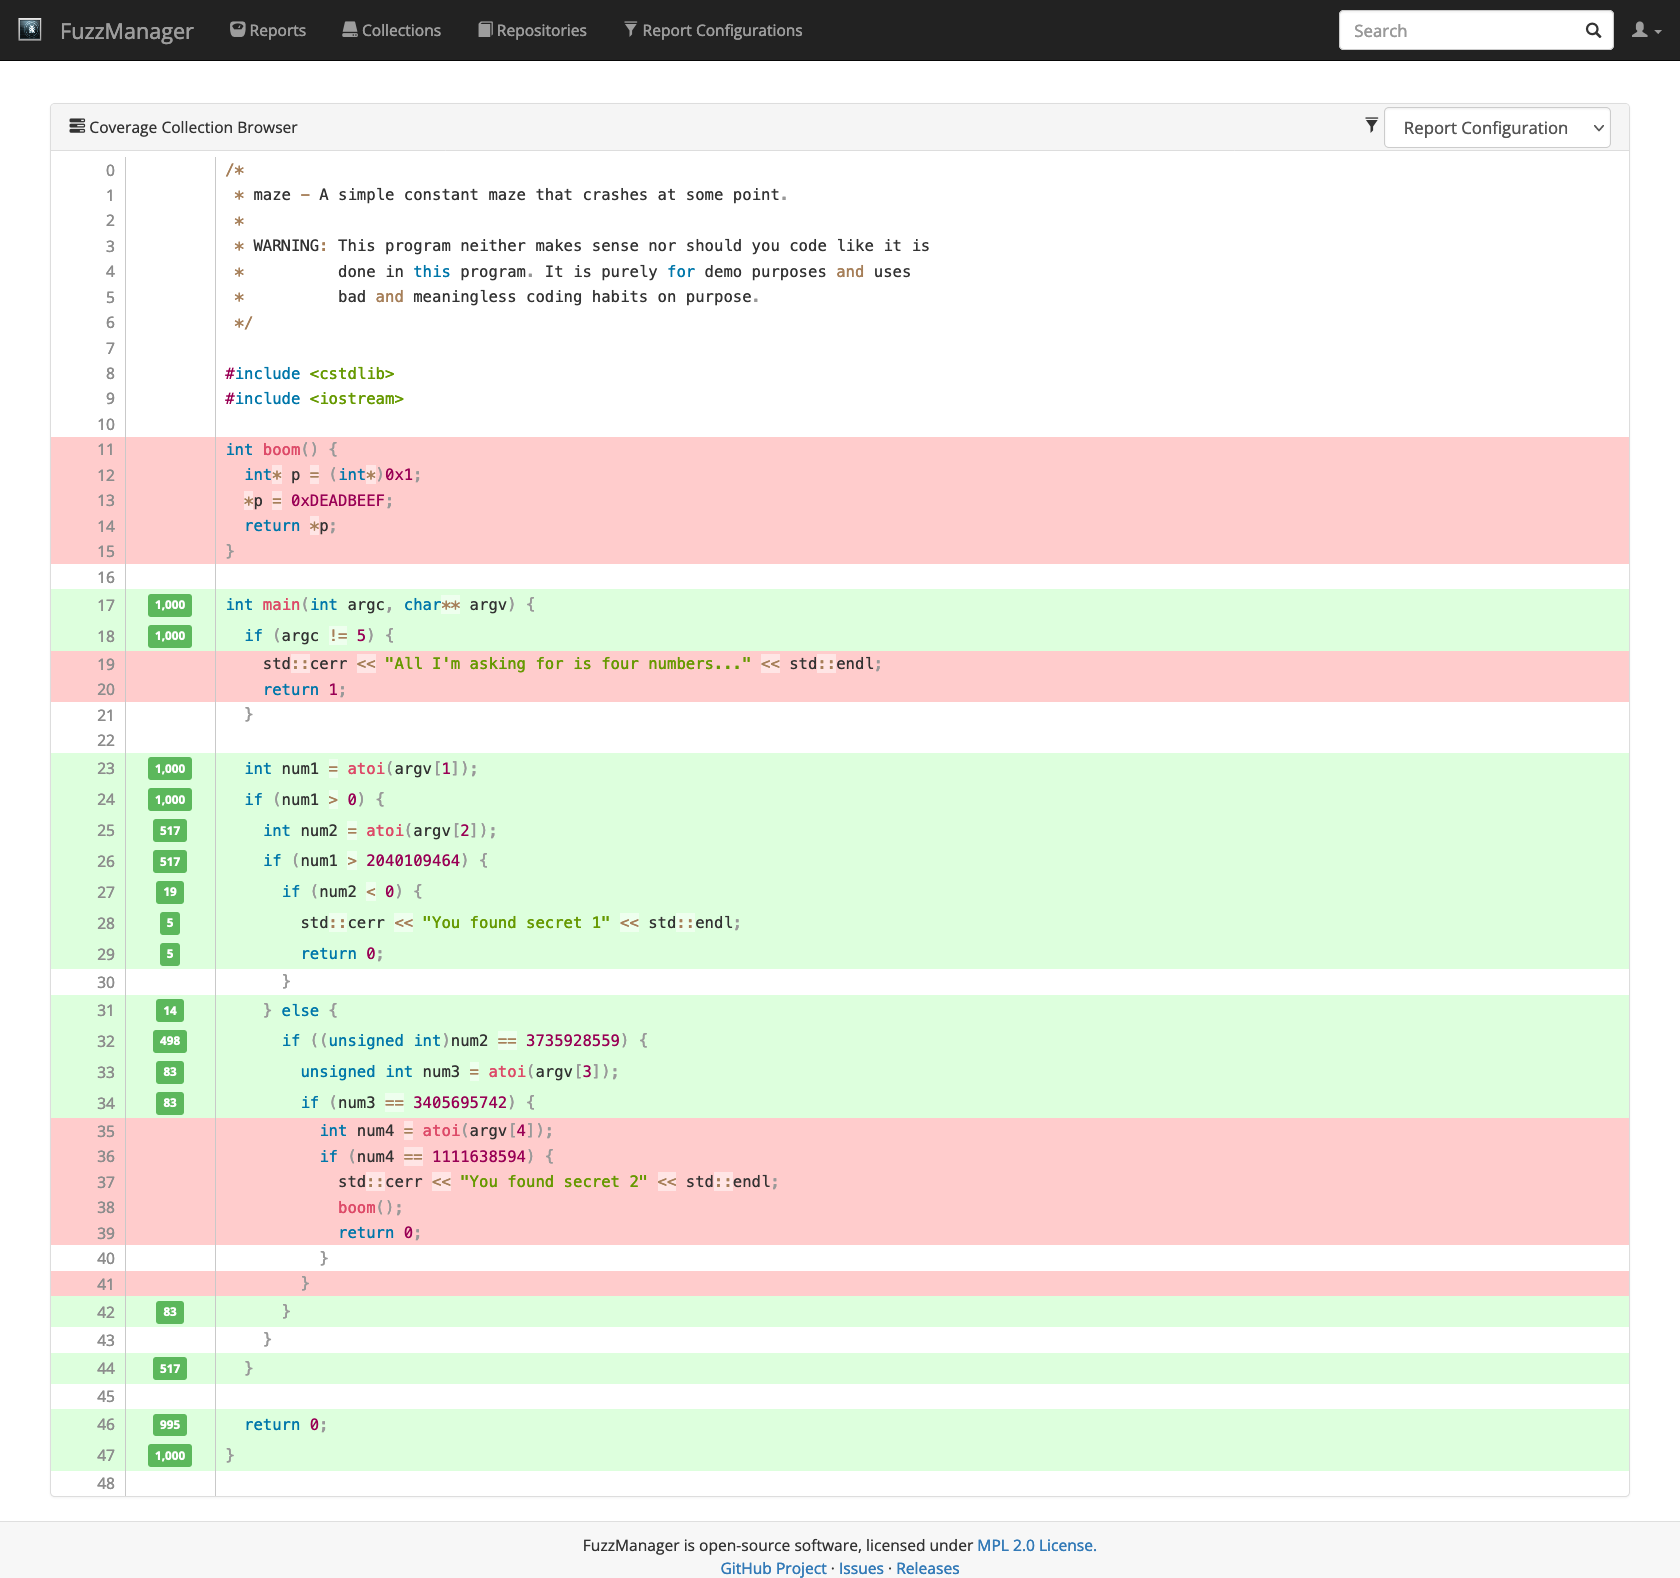

In [94]:
# ignore
gui_driver.set_window_size(1400, 1400)
Image(gui_driver.get_screenshot_as_png())

Lines highlighted in _green_ have been executed; the number in the green bar on the left tells how many times.  Lines highlighted in _red_ have _not_ been executed.  There are two observations to make:

1. The if-statement in Line 34 is still covered, but the lines following after it are red. This is because our fuzzer misses the constant checked in that statement, so it is fairly obvious that we need to add to our constants list.

2. From Line 26 to Line 27 there is a sudden drop in coverage. Both lines are covered, but the counters show that we fail that check in more than 95% of the cases. This explains why we find secret 1 so rarely. If this was a real program, we would now try to figure out how much additional code is behind that branch and adjust probabilities such that we hit it more often, if necessary.

Of course, the `maze` program is so small that one could see these issues with the bare eye. But in reality, with complex programs, it seldom obvious where a fuzzing tool gets stuck. Identifying these cases can greatly help to improve fuzzing results.

For the sake of completeness, let's rerun the program now with the missing constant added:

In [95]:
random.seed(0)
cmd = ["simply-buggy/maze"]

# Added the missing constant here
constants = [3735928559, 1111638594, 3405695742]

for itnum in range(0,1000):
    current_cmd = []
    current_cmd.extend(cmd)

    for _ in range(0,4):
        if random.randint(0, 9) < 3:
            current_cmd.append(str(
                constants[random.randint(0, len(constants) - 1)]))
        else:
            current_cmd.append(str(random.randint(-2147483647, 2147483647)))

    result = subprocess.run(current_cmd, stderr=subprocess.PIPE)
    stderr = result.stderr.decode().splitlines()
    crashed = False

    if stderr:
        print(stderr[0])

    for line in stderr:
        if "ERROR: AddressSanitizer" in line:
            crashed = True
            break

    if crashed:
        print("Found the bug!")
        break

print("Done!")

You found secret 1
You found secret 2
Found the bug!
Done!


As expected, we now found secret 2 including our crash.

## Synopsis

The Python `FuzzManager` package allows for programmatic submission of failures from a large number of (fuzzed) programs.  One can query crashes and their details, collect them into buckets to ensure thay will be treated the same, and also retrieve coverage information for debugging both programs and their tests.

## Lessons Learned

* When fuzzing (a) with several machines, (b) several programs, (c) with several fuzzers, use a _crash server_ auch as _FuzzManager_ to collect and store crashes.
* Crashes likely to be caused by the same failure should be collected in _buckets_ to ensure they all can be treated the same.
* Centrally collecting _fuzzer coverage_ can help revealing issues with fuzzers.

In [96]:
# ignore
# We're done, so we clean up
fuzzmanager_process.terminate()

In [97]:
# ignore
gui_driver.quit()

In [98]:
# ignore
import shutil

In [99]:
# ignore
for temp_file in ['coverage.json', 'geckodriver.log', 'ghostdriver.log']:
    if os.path.exists(temp_file):
        os.remove(temp_file)

In [100]:
# ignore
home = os.path.expanduser("~")
for temp_dir in ['coverage', 'simply-buggy', 'simply-buggy-server',
                 os.path.join(home, 'simply-buggy-server'),
                 'FuzzManager']:
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)

## Next Steps

In the next chapter, we will learn how to 

* estimate [how many bugs remain in the code and when we have tested enough](WhenToStopFuzzing.ipynb).


## Background

This chapter builds on the implementation of [FuzzManager](https://github.com/MozillaSecurity/FuzzManager).  Its [Github page](https://github.com/MozillaSecurity/FuzzManager) contains plenty of additional information on how to use it.

The paper "What makes a good bug report?" \cite{Bettenburg2008} lists essential information that developers expect from a bug report, how they use this information, and for which purposes.

## Exercises


### Exercise 1: Automatic Crash Reporting

Create a Python function that can be invoked at the beginning of a program to have it automatically report crashes and exceptions to a _FuzzManager_ server.  Have it track program name (and if possible, outputs) automatically; crashes (exceptions raised) should be converted into ASan format such that _FuzzManager_ can read them.

**Solution.** To be added this Summer.